In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random

In [4]:
names = open('names.txt').read().split('\n')
chars = {'.':0,}
set_chars = set()
for i in names:
    for j in str(i):
        set_chars.add(j)
for i, letter in enumerate(sorted(list(set_chars))):
    chars[letter] = i + 1
keys_chars = list(chars.keys())

In [5]:
#  ... e
#  ..e m
#  .em m
#  emm a
#  mma .
X, Y = [], []
prev_lett = 3

for name in names:
    list_to_loop_of_names = ['.'] + list(name) + ['.']
    for letter in range(len(list_to_loop_of_names)-1):
        X_here, k = [], 0
        while prev_lett-letter-k > 0:
            X_here.append(0)
            k += 1
        while len(X_here) < prev_lett:
            # print(letter, len(X_here))
            X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
        X.append(X_here)
        Y.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
def make_dataset(names):
    Xs, Ys = [], []
    for name in names:
        list_to_loop_of_names = ['.'] + list(name) + ['.']
        for letter in range(len(list_to_loop_of_names)-1):
            X_here, k = [], 0
            while prev_lett-letter-k > 0:
                X_here.append(0)
                k += 1
            while len(X_here) < prev_lett:
                X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
            Xs.append(X_here)
            Ys.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
    return torch.tensor(Xs), torch.tensor(Ys)
random.shuffle(names)
n1, n2 = int(0.8 * len(names)), int(0.9 * len(names))
Xtrain, Ytrain = make_dataset(names[:n1])
Xval, Yval = make_dataset(names[n1:n2])
Xtest, Ytest = make_dataset(names[n2:])

In [7]:
# CONSTS 
num_dim = 30
num_input = prev_lett*num_dim
num_W1 = 100
num_W2 = 27
batch_size = 32

In [61]:
g = torch.Generator()
g.manual_seed(2147483647)

C = torch.randn(27, num_dim)
W1 = torch.randn(num_input, num_W1) * 0.3
b1 = torch.randn(num_W1) * 0
W2 = torch.randn(num_W1, num_W2) * 0.1
b2 = torch.randn(num_W2) * 0

bn_bias = torch.zeros((1, num_W1))
bn_mult = torch.ones((1, num_W1))

bn_mean_mean = torch.zeros((1, num_W1))
bn_std_mean = torch.ones((1, num_W1))

P = [C, W1, b1, W2, b2, bn_bias, bn_mult]
for p in P:
    p.requires_grad = True

In [106]:
epochs = 70000
steps, losses = [], []
for epoch in range(epochs):
    samples_on_this_epoch = torch.randint(0, len(Xtrain), (batch_size,))
    X_on_this_epoch = C[Xtrain[samples_on_this_epoch]].view(-1, prev_lett*num_dim)
    Y_on_this_epoch = Ytrain[samples_on_this_epoch]
    # first_stage = C[X] 
    h1 = X_on_this_epoch @ W1 + b1
    h1_mean_this_stage = h1.mean(0, keepdims=True)
    h1_std_this_stage = h1.std(0, keepdims=True)
    h1 = bn_mult * (h1 - h1_mean_this_stage)/(h1_std_this_stage+ 0.0001) + bn_bias
    h1 = torch.tanh(h1)
    output = h1 @ W2 + b2

    with torch.no_grad():
        bn_mean_mean = 0.999 * bn_mean_mean + 0.001 * h1_mean_this_stage
        bn_std_mean = 0.999 * bn_std_mean + 0.001 * h1_std_this_stage

    loss = F.cross_entropy(output, Y_on_this_epoch)
    for p in P:
        p.grad = None
    loss.backward()
    lr = 0.1 if epoch/epochs < 0.3 else 0.01

    for p in P:
        p.data += -lr * p.grad
    # W1.data += -lr * W1.grad
    # W2.data += -lr * W2.grad
    # b1.data += -lr * b1.grad
    # b2.data += -lr * b2.grad

    steps.append(epoch)
    losses.append(loss.item())


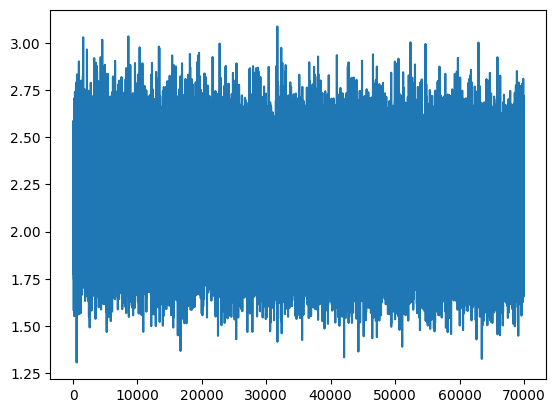

In [107]:
plt.plot(steps, losses);

In [118]:
def check_loss(dataX, dataY):
    losses_checker = []
    for i in range(100):
        # samples_on_this_epoch = torch.randint(0, len(dataX), (batch_size,))
        X_on_this_epoch = C[dataX].view(-1, prev_lett*num_dim)
        Y_on_this_epoch = dataY
        # first_stage = C[X] 
        h1 = X_on_this_epoch @ W1 + b1
        h1 = bn_mult * (h1 - bn_mean_mean)/(bn_std_mean+ 0.0001) + bn_bias
        h1 = torch.tanh(h1)
        output = h1 @ W2 + b2
    
        loss = F.cross_entropy(output, Y_on_this_epoch)
        losses_checker.append(loss.item())
    return torch.tensor(losses_checker).mean().item()

In [119]:
print(check_loss(Xval, Yval))
print(check_loss(Xtest, Ytest))


2.1321845054626465
2.137974500656128


In [110]:
examples = []
for i in range(15):
    inp_letters = [0, 0, 0]
    example = []
    while True:
        lol = torch.tensor(inp_letters)
        X_on_this_epoch = C[lol].view(-1, prev_lett*num_dim)
        
        h1 = X_on_this_epoch @ W1 + b1
        h1 = bn_mult * (h1 - bn_mean_mean)/(bn_std_mean+ 0.0001) + bn_bias
        h1 = torch.tanh(h1)
        output = h1 @ W2 + b2
        
        probs = output.exp()/torch.sum(output.exp(), dim=1, keepdim=True)
        letter = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        inp_letters.append(letter)
        inp_letters.pop(0)
        example.append(keys_chars[letter])
        letter = keys_chars[letter]
        if letter == '.':
            break
    examples.append(''.join(example))
print(examples)

['ahleva.', 'cara.', 'raydehuaniyah.', 'malyn.', 'brey.', 'jui.', 'laveron.', 'lihamirahawn.', 'luc.', 'sely.', 'kavishtikeysa.', 'aeverin.', 'nolw.', 'fabrenella.', 'anellyn.']


In [111]:
for i in examples:
    print(f'- {i}')
    # print('\n')
    

- ahleva.
- cara.
- raydehuaniyah.
- malyn.
- brey.
- jui.
- laveron.
- lihamirahawn.
- luc.
- sely.
- kavishtikeysa.
- aeverin.
- nolw.
- fabrenella.
- anellyn.


In [206]:
class Linear:
    
    def __init__(self, inp_neur, out_neur, bias_req=True):
        self.weights = torch.randn(inp_neur, out_neur)
        if bias_req: self.bias = torch.zeros(out_neur)
        else:        self.bias = None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias != None: self.out += self.bias
        return self.out

    def params(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])


class batchNormal:
    def __init__(self, neur, calc_mean=True, e=0.0001, momentum=0.01):
        self.momentum = momentum
        self.e = e
        self.weights = torch.ones((1, neur))
        self.bias = torch.zeros((1, neur))
        self.training = True

        if calc_mean:
            self.mean_mean = torch.zeros((1, neur))
            self.std_mean = torch.ones((1, neur))
        else:
            self.mean_mean = None
            self.std_mean = None

    def __call__(self, x):
        if self.training:
            x_mean_now = x.mean(0, keepdims=True)
            x_std_now = x.std(0, keepdims=True)
        else:
            x_mean_now = self.mean_mean
            x_std_now = self.std_mean
        self.out = self.weights * (x - x_mean_now)/(x_std_now + e) + self.bias

        if self.training:
            if self.mean_mean != None:
                with torch.no_grad():
                    self.mean_mean = (1 - momentum) * self.mean_mean + self.momentum * x_mean_now
                    self.std_mean = (1 - momentum) * self.std_mean + self.momentum * x_std_now

        return self.out

    def params(self):
        return [self.weights, self.bias]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def params(self):
        return []

In [207]:
# CONSTS 
num_dim = 30
num_input = prev_lett * num_dim
num_W1 = 100
num_W2 = 27
batch_size = 32

In [208]:
C = torch.randn(27, num_dim)
layers = [
    Linear(num_input, num_W1), Tanh(),
    Linear(num_W1, num_W2),
]
with torch.no_grad():
    layers[-1].weights *= 0.1

P = [C] + [p for layer in layers for p in layer.params()]
for p in P:
    p.requires_grad = True

In [209]:
epochs = 10000
steps, losses = [], []
for epoch in range(epochs):
    samples_on_this_epoch = torch.randint(0, len(Xtrain), (batch_size,))
    X_on_this_epoch = C[Xtrain[samples_on_this_epoch]].view(C[Xtrain[samples_on_this_epoch]].shape[0], -1)
    Y_on_this_epoch = Ytrain[samples_on_this_epoch]
    for layer in layers:
        X_on_this_epoch = layer(X_on_this_epoch)

    loss = F.cross_entropy(X_on_this_epoch, Y_on_this_epoch)
    
    for p in P:
        p.grad = None
        
    loss.backward()
    lr = 0.1 if epoch/epochs < 0.3 else 0.01

    for p in P:
        p.data += -lr * p.grad

    steps.append(epoch)
    losses.append(loss.item())


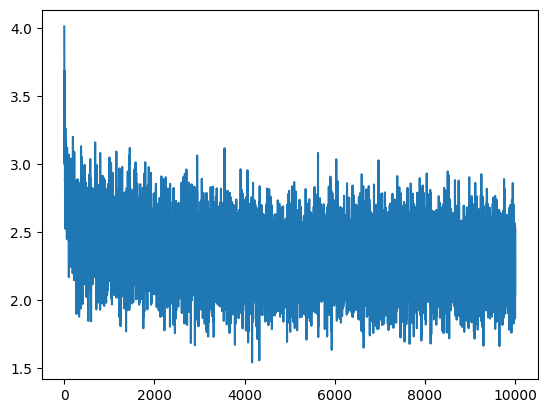

In [210]:
plt.plot(steps, losses);